Toxicity Dataset : https://archive.ics.uci.edu/dataset/728/toxicity-2

The dataset includes 171 molecules designed for functional domains of a core clock protein, CRY1, responsible for generating circadian rhythm. 56 of the molecules are toxic and the rest are non-toxic. 

The data consists a complete set of 1203 molecular descriptors and needs feature selection before classification since some of the features are redundant. 

Introductory Paper:
Structure-based design and classifications of small molecules regulating the circadian rhythm period
By Seref Gul, F. Rahim, Safak Isin, Fatma Yilmaz, Nuri Ozturk, M. Turkay, I. Kavakli. 2021
https://www.semanticscholar.org/paper/Structure-based-design-and-classifications-of-small-Gul-Rahim/5944836c47bc7d1a2b0464a9a1db94d4bc7f28ce

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier, SGDClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
data = fetch_ucirepo(id=728) 
  
# data (as pandas dataframes) 
X = data.data.features 
y = data.data.targets 

In [4]:
X.head()

,MATS3v,nHBint10,MATS3s,MATS3p,nHBDon_Lipinski,minHBint8,MATS3e,MATS3c,minHBint2,MATS3m,...,WTPT-3,WTPT-4,WTPT-5,ETA_EtaP_L,ETA_EtaP_F,ETA_EtaP_B,nT5Ring,SHdNH,ETA_dEpsilon_C,MDEO-22
0,0.0908,0,0.0075,0.0173,0,0.0,-0.0436,0.0409,0.0,0.1368,...,0.0000,0.0000,0.0000,0.1780,1.5488,0.0088,0,0.0,-0.0868,0.00
1,0.0213,0,0.1144,-0.0410,0,0.0,0.1231,-0.0316,0.0,0.1318,...,28.2185,8.8660,19.3525,0.1739,1.3718,0.0048,2,0.0,-0.0810,0.25
2,0.0018,0,-0.0156,-0.0765,2,0.0,-0.1138,-0.1791,0.0,0.0615,...,33.1064,5.2267,27.8796,0.1688,1.4395,0.0116,2,0.0,-0.1004,0.00
3,-0.0251,0,-0.0064,-0.0894,3,0.0,-0.0747,-0.1151,0.0,0.0361,...,32.5232,7.7896,24.7336,0.1702,1.4654,0.0133,2,0.0,-0.1010,0.00
4,0.0135,0,0.0424,-0.0353,0,0.0,-0.0638,0.0307,0.0,0.0306,...,32.0726,12.3240,19.7486,0.1789,1.4495,0.0120,2,0.0,-0.1071,0.00


In [5]:
y.head()

,Class
0,NonToxic
1,NonToxic
2,NonToxic
3,NonToxic
4,NonToxic


In [6]:
# Load and preprocess data
y_binary = (y['Class'] == 'NonToxic').astype(int)

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Class distribution:\n{y['Class'].value_counts()}")
print(f"Class balance:\n{y['Class'].value_counts(normalize=True)}")


Feature matrix shape: (171, 1203)
Target shape: (171, 1)
Class distribution:
Class
NonToxic    115
Toxic        56
Name: count, dtype: int64
Class balance:
Class
NonToxic    0.672515
Toxic       0.327485
Name: proportion, dtype: float64


In [7]:
# Shuffle and split
np.random.seed(42)
shuffle_idx = np.random.permutation(len(X))
X_shuffled, y_shuffled = X.iloc[shuffle_idx].reset_index(drop=True), y_binary.iloc[shuffle_idx].reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=42, stratify=y_shuffled)

In [8]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
print(f"Training set: {X_train_scaled.shape}, Test set: {X_test_scaled.shape}")

Training set: (136, 1203), Test set: (35, 1203)


In [10]:
# Define models to compare
models = {
    # === LINEAR MODELS ===
    'LR_No_Penalty': LogisticRegression(penalty=None, max_iter=2000, solver='lbfgs'),
    'LR_Ridge_C1': LogisticRegression(penalty='l2', C=1.0, max_iter=2000, solver='lbfgs'),
    'LR_Ridge_C0.1': LogisticRegression(penalty='l2', C=0.1, max_iter=2000, solver='lbfgs'),
    'LR_Ridge_C10': LogisticRegression(penalty='l2', C=10.0, max_iter=2000, solver='lbfgs'),
    'LR_Lasso_C1': LogisticRegression(penalty='l1', C=1.0, max_iter=2000, solver='saga'),
    'LR_Lasso_C0.1': LogisticRegression(penalty='l1', C=0.1, max_iter=2000, solver='saga'),
    'LR_ElasticNet_L1_0.5': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0, max_iter=2000),
    'LR_ElasticNet_L1_0.7': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.7, C=1.0, max_iter=2000),
    'Ridge_Classifier': RidgeClassifier(alpha=1.0),
    'SGD_Classifier': SGDClassifier(loss='log_loss', max_iter=2000, random_state=42),
    
    # === DISCRIMINANT ANALYSIS ===
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    
    # === NAIVE BAYES ===
    'Naive_Bayes': GaussianNB(),
    
    # === TREE-BASED MODELS ===
    'Decision_Tree_D5': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Decision_Tree_D10': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Decision_Tree_D20': DecisionTreeClassifier(max_depth=20, random_state=42),
    'Decision_Tree_Unpruned': DecisionTreeClassifier(random_state=42),
    
    # === ENSEMBLE MODELS - BAGGING ===
    'Random_Forest_N50': RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
    'Random_Forest_N100': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Random_Forest_N200': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    'Random_Forest_Deep': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42),
    'Extra_Trees_N100': ExtraTreesClassifier(n_estimators=100, max_depth=10, random_state=42),
    
    # === ENSEMBLE MODELS - BOOSTING ===
    'AdaBoost_N50': AdaBoostClassifier(n_estimators=50, random_state=42, algorithm='SAMME'),
    'AdaBoost_N100': AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME'),
    'GradientBoosting_N50': GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42),
    'GradientBoosting_N100': GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42),
    'XGBoost_D3_N50': XGBClassifier(max_depth=3, n_estimators=50, random_state=42, eval_metric='logloss', use_label_encoder=False),
    'XGBoost_D3_N100': XGBClassifier(max_depth=3, n_estimators=100, random_state=42, eval_metric='logloss', use_label_encoder=False),
    'XGBoost_D5_N100': XGBClassifier(max_depth=5, n_estimators=100, random_state=42, eval_metric='logloss', use_label_encoder=False),
    
    # === SVM VARIATIONS ===
    'SVM_Linear': SVC(kernel='linear', probability=True, random_state=42),
    'SVM_RBF_C1': SVC(kernel='rbf', C=1.0, probability=True, random_state=42), # Radial Basis Function kernel
    'SVM_RBF_C10': SVC(kernel='rbf', C=10.0, probability=True, random_state=42),
    'SVM_Poly_D2': SVC(kernel='poly', degree=2, probability=True, random_state=42), # Polynomial kernel degree 2
    'SVM_Poly_D3': SVC(kernel='poly', degree=3, probability=True, random_state=42),
    
    # === K-NEAREST NEIGHBORS ===
    'KNN_K3': KNeighborsClassifier(n_neighbors=3), # K-Nearest Neighbors with k=3 
    'KNN_K5': KNeighborsClassifier(n_neighbors=5),
    'KNN_K7': KNeighborsClassifier(n_neighbors=7),
    'KNN_K10': KNeighborsClassifier(n_neighbors=10),
    
    # === NEURAL NETWORKS ===
    'NN_Small': MLPClassifier(hidden_layer_sizes=(25,), max_iter=1000, random_state=42, early_stopping=True, solver='lbfgs'),
    'NN_Medium': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=1000, random_state=42, early_stopping=True, solver='lbfgs'),
    'NN_Large': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True, solver='lbfgs'),
    'NN_Deep': MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=1000, random_state=42, early_stopping=True, solver='lbfgs'),
    'NN_Adam': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=1000, random_state=42, early_stopping=True, solver='adam'),
}

In [11]:
# Evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate a classification model and return metrics"""
    X_train_selected, X_test_selected = X_train, X_test
    model.fit(X_train_selected, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)
    
    # Probabilities
    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train_selected)[:, 1]
        y_test_proba = model.predict_proba(X_test_selected)[:, 1]
    else:
        y_train_proba = model.decision_function(X_train_selected)
        y_test_proba = model.decision_function(X_test_selected)
    
    return {
        'train_acc': accuracy_score(y_train, y_train_pred),
        'test_acc': accuracy_score(y_test, y_test_pred),
        'train_auc': roc_auc_score(y_train, y_train_proba),
        'test_auc': roc_auc_score(y_test, y_test_proba),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred)
    }

In [12]:
# Train and evaluate all models (WITHOUT class weights)
print("\n" + "="*80)
print("TRAINING MODELS WITHOUT CLASS WEIGHTS")
print("="*80)
results = []
for name, model in models.items():
    print(f"Training {name}...")
    metrics = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    metrics['model'] = name
    results.append(metrics)
    print(f"  Test Accuracy: {metrics['test_acc']:.4f}, Test AUC: {metrics['test_auc']:.4f}")



TRAINING MODELS WITHOUT CLASS WEIGHTS
Training LR_No_Penalty...
  Test Accuracy: 0.6000, Test AUC: 0.5833
Training LR_Ridge_C1...
  Test Accuracy: 0.5714, Test AUC: 0.5682
Training LR_Ridge_C0.1...
  Test Accuracy: 0.5714, Test AUC: 0.5758
Training LR_Ridge_C10...
  Test Accuracy: 0.5429, Test AUC: 0.5530
Training LR_Lasso_C1...
  Test Accuracy: 0.6000, Test AUC: 0.5455
Training LR_Lasso_C0.1...
  Test Accuracy: 0.6857, Test AUC: 0.5644
Training LR_ElasticNet_L1_0.5...
  Test Accuracy: 0.6000, Test AUC: 0.5417
Training LR_ElasticNet_L1_0.7...
  Test Accuracy: 0.6000, Test AUC: 0.5417
Training Ridge_Classifier...
  Test Accuracy: 0.5143, Test AUC: 0.5492
Training SGD_Classifier...
  Test Accuracy: 0.5714, Test AUC: 0.4924
Training LDA...
  Test Accuracy: 0.6000, Test AUC: 0.5473
Training QDA...
  Test Accuracy: 0.6286, Test AUC: 0.6307
Training Naive_Bayes...
  Test Accuracy: 0.4286, Test AUC: 0.5076
Training Decision_Tree_D5...
  Test Accuracy: 0.6286, Test AUC: 0.5795
Training Decisi

In [13]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df[['model', 'train_acc', 'test_acc', 'train_auc', 'test_auc', 'precision', 'recall', 'f1']]
results_df = results_df.sort_values('test_acc', ascending=False).reset_index(drop=True)

print("\n=== MODEL COMPARISON (NO CLASS WEIGHTS) ===")
print(results_df.to_string(index=False))


=== MODEL COMPARISON (NO CLASS WEIGHTS) ===
                 model  train_acc  test_acc  train_auc  test_auc  precision   recall       f1
         LR_Lasso_C0.1   0.669118  0.685714   0.723077  0.564394   0.685714 1.000000 0.813559
           SVM_Poly_D3   0.720588  0.685714   0.006105  0.333333   0.685714 1.000000 0.813559
           SVM_Poly_D2   0.720588  0.685714   0.011966  0.382576   0.685714 1.000000 0.813559
            SVM_RBF_C1   0.727941  0.685714   0.010501  0.382576   0.685714 1.000000 0.813559
                KNN_K3   0.757353  0.657143   0.779487  0.695076   0.750000 0.750000 0.750000
 GradientBoosting_N100   1.000000  0.657143   1.000000  0.625000   0.730769 0.791667 0.760000
       XGBoost_D3_N100   1.000000  0.657143   1.000000  0.681818   0.730769 0.791667 0.760000
     Random_Forest_N50   1.000000  0.657143   1.000000  0.638258   0.714286 0.833333 0.769231
        XGBoost_D3_N50   1.000000  0.657143   1.000000  0.689394   0.750000 0.750000 0.750000
               

In [14]:
# ===== FEATURE IMPORTANCE ANALYSIS =====
print("\n" + "="*80)
print("FEATURE IMPORTANCE COMPARISON WITH ORIGINAL STUDY")
print("="*80)

# Original study's important features
original_features = ['MDEC-23', 'MATS2v', 'ATSC8s', 'VE3_Dt', 'CrippenMR', 'SpMax7_Bhe',
                     'SpMin1_Bhs', 'C1SP2', 'GATS8e', 'GATS8s', 'SpMax5_Bhv', 'VE3_Dzi', 'VPC-4']

feature_names = X.columns.tolist()


FEATURE IMPORTANCE COMPARISON WITH ORIGINAL STUDY


In [15]:
def get_feature_importance(model, model_name, X_train, X_test, y_train, y_test):
    """Extract feature importance for different model types"""
    # Tree-based models: use built-in feature_importances_
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        method = "Built-in (Impurity-based)"
    # Linear models: use absolute coefficient values
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
        method = "Coefficients"
    # Other models: use permutation importance
    else:
        perm_importance = permutation_importance(
            model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
        )
        importances = perm_importance.importances_mean
        method = "Permutation"
    
    # Create DataFrame with feature importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    return importance_df, method

In [16]:
# Extract feature importance for each trained model
print(f"\nOriginal study identified {len(original_features)} important features using DTC:")
print(original_features)
print("\n" + "-"*80)


Original study identified 13 important features using DTC:
['MDEC-23', 'MATS2v', 'ATSC8s', 'VE3_Dt', 'CrippenMR', 'SpMax7_Bhe', 'SpMin1_Bhs', 'C1SP2', 'GATS8e', 'GATS8s', 'SpMax5_Bhv', 'VE3_Dzi', 'VPC-4']

--------------------------------------------------------------------------------


In [ ]:
feature_comparison = {}

for name, model in models.items():
    print(f"\n### {name} ###")
    
    # Get feature importance
    importance_df, method = get_feature_importance(model, name, X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Get top 13 features (same number as original study)
    top_13 = importance_df.head(13)
    top_13_features = top_13['feature'].tolist()
    
    # Calculate overlap with original study
    overlap = set(top_13_features) & set(original_features)
    overlap_count = len(overlap)
    overlap_pct = (overlap_count / len(original_features)) * 100
    
    print(f"Method: {method}")
    print(f"\nTop 13 Features:")
    print(top_13.to_string(index=False))
    print(f"\nOverlap with original study: {overlap_count}/{len(original_features)} ({overlap_pct:.1f}%)")
    if overlap:
        print(f"Matching features: {sorted(overlap)}")
    
    feature_comparison[name] = {
        'top_13': top_13_features,
        'overlap_count': overlap_count,
        'overlap_features': sorted(overlap),
        'method': method
    }



### LR_No_Penalty ###
Method: Coefficients

Top 13 Features:
        feature  importance
           JGI7    2.662786
       maxsssCH    2.418668
        nHBint3    2.211286
      topoShape    2.167554
         ALogp2    2.109908
         WTPT-2    2.085124
PetitjeanNumber    2.066339
      minHBint4    2.025087
          C3SP3    2.014067
      maxHBint4    1.973907
        minssNH    1.912443
        maxssNH    1.885499
        nHBint5    1.844436

Overlap with original study: 0/13 (0.0%)

### LR_Ridge_C1 ###
Method: Coefficients

Top 13 Features:
  feature  importance
   ALogp2    0.485003
 BCUTw-1l    0.451027
    minsF    0.419858
 maxsssCH    0.418539
    maxsF    0.408744
    nBase    0.396709
  minssNH    0.381352
   MATS1s    0.373229
  maxssNH    0.368279
maxHBint5    0.357640
  VE3_Dzs    0.347557
    C3SP3    0.344547
minHCsatu    0.337992

Overlap with original study: 0/13 (0.0%)

### LR_Ridge_C0.1 ###
Method: Coefficients

Top 13 Features:
  feature  importance
   ALogp2 

In [21]:
# Summary comparison table
print("\n" + "="*80)
print("SUMMARY: OVERLAP WITH ORIGINAL STUDY")
print("="*80)
summary_df = pd.DataFrame({
    'Model': list(feature_comparison.keys()),
    'Overlap Count': [v['overlap_count'] for v in feature_comparison.values()],
    'Overlap %': [(v['overlap_count']/13)*100 for v in feature_comparison.values()],
    'Method': [v['method'] for v in feature_comparison.values()]
}).sort_values('Overlap Count', ascending=False)

print(summary_df.to_string(index=False))


SUMMARY: OVERLAP WITH ORIGINAL STUDY
                 Model  Overlap Count  Overlap %                    Method
          AdaBoost_N50              2  15.384615 Built-in (Impurity-based)
         AdaBoost_N100              1   7.692308 Built-in (Impurity-based)
              NN_Large              1   7.692308               Permutation
             NN_Medium              1   7.692308               Permutation
           LR_Lasso_C1              0   0.000000              Coefficients
         LR_Lasso_C0.1              0   0.000000              Coefficients
  LR_ElasticNet_L1_0.5              0   0.000000              Coefficients
          LR_Ridge_C10              0   0.000000              Coefficients
         LR_No_Penalty              0   0.000000              Coefficients
           LR_Ridge_C1              0   0.000000              Coefficients
         LR_Ridge_C0.1              0   0.000000              Coefficients
                   LDA              0   0.000000              

In [22]:
# Find features commonly selected across multiple models
print("\n" + "="*80)
print("FEATURES SELECTED BY MULTIPLE MODELS (in top 13)")
print("="*80)

all_top_features = []
for comp in feature_comparison.values():
    all_top_features.extend(comp['top_13'])

feature_counts = pd.Series(all_top_features).value_counts()
frequent_features = feature_counts[feature_counts >= 3]

if len(frequent_features) > 0:
    print(f"\nFeatures selected by 3+ models:")
    for feat, count in frequent_features.items():
        in_original = "✓" if feat in original_features else " "
        print(f"  [{in_original}] {feat}: {count}/{len(models)} models")
else:
    print("No features were consistently selected across 3+ models")


FEATURES SELECTED BY MULTIPLE MODELS (in top 13)

Features selected by 3+ models:
  [ ] minssNH: 12/43 models
  [ ] SpDiam_Dt: 12/43 models
  [ ] maxssNH: 10/43 models
  [ ] maxHaaCH: 10/43 models
  [ ] ALogp2: 9/43 models
  [ ] MATS1s: 8/43 models
  [ ] AATSC4m: 8/43 models
  [ ] minsF: 8/43 models
  [ ] nBase: 8/43 models
  [ ] ATSC3v: 8/43 models
  [ ] MDEO-22: 7/43 models
  [ ] maxHBint4: 7/43 models
  [ ] maxsF: 7/43 models
  [ ] VE1_D: 7/43 models
  [ ] JGI7: 7/43 models
  [ ] C3SP3: 7/43 models
  [ ] MATS3v: 7/43 models
  [ ] maxsssCH: 7/43 models
  [ ] minHCsatu: 6/43 models
  [ ] VE3_D: 6/43 models
  [ ] AATSC1s: 6/43 models
  [ ] minHBint4: 6/43 models
  [ ] AATSC1c: 6/43 models
  [ ] nHBint10: 6/43 models
  [ ] nsCl: 6/43 models
  [ ] AATSC1v: 6/43 models
  [ ] VE1_Dt: 6/43 models
  [ ] ATS5v: 6/43 models
  [ ] nHBAcc: 6/43 models
  [ ] AATSC1m: 6/43 models
  [ ] MATS5i: 5/43 models
  [ ] topoShape: 5/43 models
  [ ] maxHBint5: 5/43 models
  [ ] SpMax4_Bhm: 5/43 models
  [ 

In [23]:
# Save detailed comparison
comparison_results = []
for model_name, comp in feature_comparison.items():
    for i, feat in enumerate(comp['top_13'], 1):
        comparison_results.append({
            'model': model_name,
            'rank': i,
            'feature': feat,
            'in_original_study': feat in original_features
        })

comparison_df = pd.DataFrame(comparison_results)
comparison_df
# comparison_df.to_csv('feature_importance_comparison.csv', index=False)
# print("\n✓ Feature importance saved to 'feature_importance_comparison.csv'")

,model,rank,feature,in_original_study
0,LR_No_Penalty,1,JGI7,False
1,LR_No_Penalty,2,maxsssCH,False
2,LR_No_Penalty,3,nHBint3,False
3,LR_No_Penalty,4,topoShape,False
4,LR_No_Penalty,5,ALogp2,False
...,...,...,...,...
554,NN_Adam,9,maxaaN,False
555,NN_Adam,10,MATS1v,False
556,NN_Adam,11,minaaN,False
557,NN_Adam,12,minssNH,False


In [24]:
# ==========================================
# VISUALIZATION MODULE - REFACTORED
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==========================================
# CONFIGURATION
# ==========================================
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


In [25]:
# ==========================================
# UTILITY FUNCTIONS
# ==========================================

def assign_model_group(name):
    """Categorize models into standardized groups."""
    categories = {
        'Linear / Penalized': ['LR_', 'Ridge_Classifier', 'SGD_Classifier'],
        'Single Tree': ['Decision_Tree'],
        'Random Forest / ExtraTrees': ['Random_Forest', 'Extra_Trees'],
        'Boosting Ensembles': ['AdaBoost', 'GradientBoosting', 'XGBoost'],
        'SVM': ['SVM_'],
        'KNN': ['KNN_'],
        'Neural Networks': ['NN_'],
        'Discriminant Analysis': ['LDA', 'QDA'],
        'Naive Bayes': ['Naive_Bayes']
    }
    
    for group, keywords in categories.items():
        if any(keyword in name for keyword in keywords):
            return group
    return 'Other'


def prepare_data(results_df, results_df_weighted=None):
    """Add model groups and prepare data for visualization."""
    results_df['Group'] = results_df['model'].apply(assign_model_group)
    
    if results_df_weighted is not None:
        results_df_weighted['Group'] = results_df_weighted['model'].apply(assign_model_group)
        results_df_weighted['model'] = results_df_weighted['model'] + ' (weighted)'
        return results_df, results_df_weighted
    
    return results_df, results_df_weighted



In [28]:
prepare_data(results_df)

(                     model  train_acc  test_acc  train_auc  test_auc  \
 0            LR_Lasso_C0.1   0.669118  0.685714   0.723077  0.564394   
 1              SVM_Poly_D3   0.720588  0.685714   0.006105  0.333333   
 2              SVM_Poly_D2   0.720588  0.685714   0.011966  0.382576   
 3               SVM_RBF_C1   0.727941  0.685714   0.010501  0.382576   
 4                   KNN_K3   0.757353  0.657143   0.779487  0.695076   
 5    GradientBoosting_N100   1.000000  0.657143   1.000000  0.625000   
 6          XGBoost_D3_N100   1.000000  0.657143   1.000000  0.681818   
 7        Random_Forest_N50   1.000000  0.657143   1.000000  0.638258   
 8           XGBoost_D3_N50   1.000000  0.657143   1.000000  0.689394   
 9                   KNN_K7   0.727941  0.657143   0.728816  0.666667   
 10                  KNN_K5   0.713235  0.657143   0.757021  0.702652   
 11                 KNN_K10   0.654412  0.657143   0.682051  0.655303   
 12    GradientBoosting_N50   1.000000  0.628571   

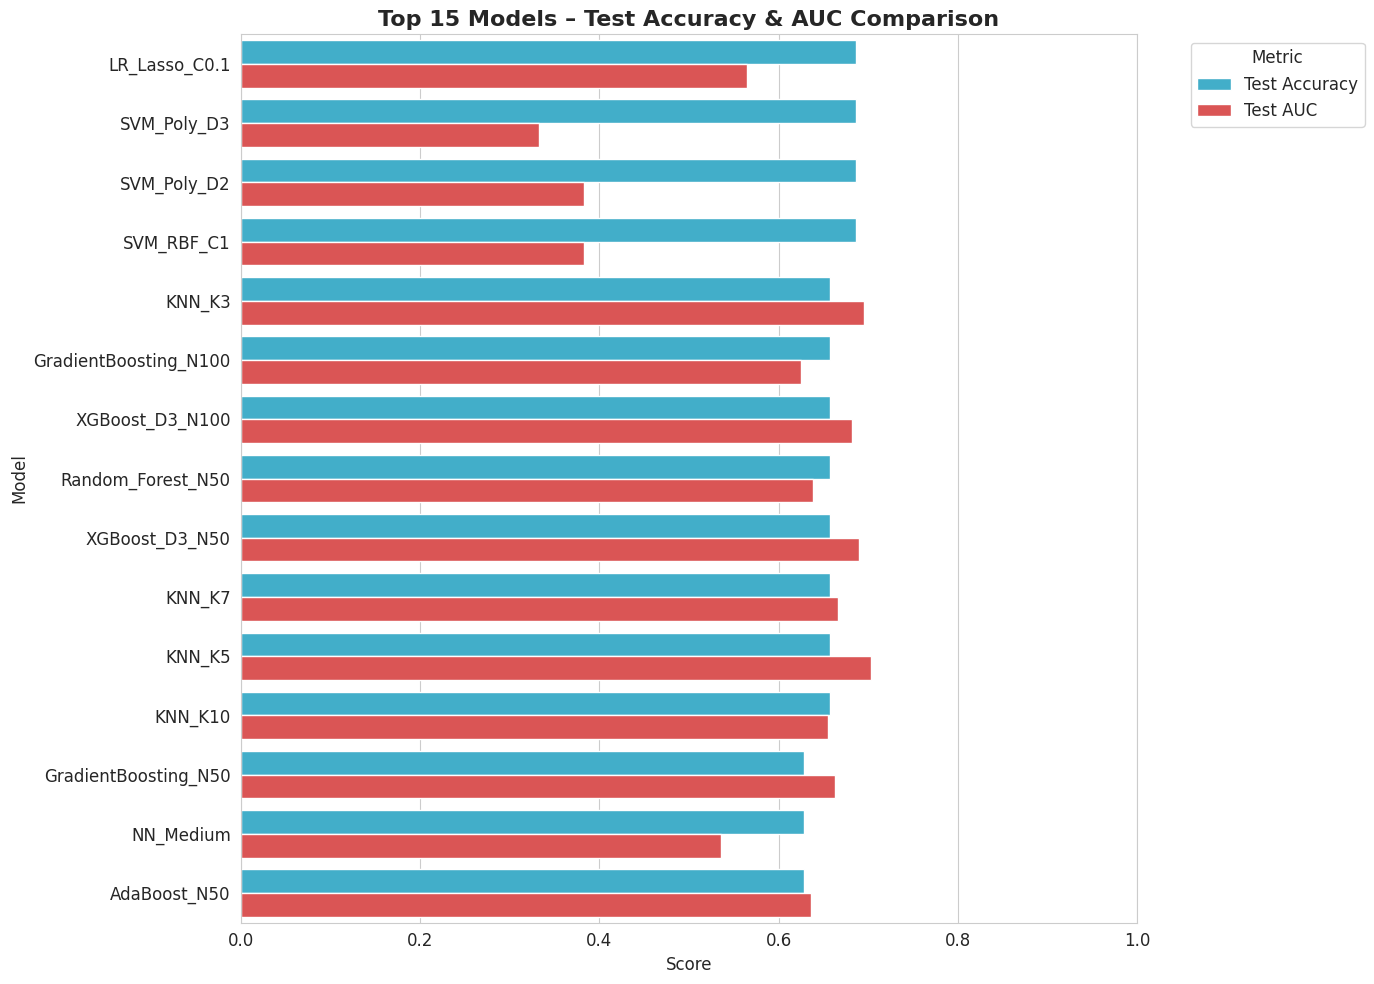

In [29]:

def plot_top_models(results_df, n=15):
    """Plot top N models with grouped bars for test accuracy and AUC."""
    top_n = results_df.head(n).copy()
    
    # Reshape data for grouped bar chart
    plot_data = top_n.melt(
        id_vars=['model', 'Group'], 
        value_vars=['test_acc', 'test_auc'],
        var_name='Metric', 
        value_name='Score'
    )
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 10))
    
    sns.barplot(
        data=plot_data, 
        y='model', 
        x='Score', 
        hue='Metric',
        dodge=True,
        ax=ax, 
        palette={'test_acc': "#2bbbdf", 'test_auc': "#f03f3f"}
    )
    
    ax.set_title(f'Top {n} Models – Test Accuracy & AUC Comparison', 
                 fontsize=16, weight='bold')
    ax.set_xlabel('Score', fontsize=12)
    ax.set_ylabel('Model', fontsize=12)
    ax.set_xlim(0, 1)
    
    # Get handles and labels, then update legend with custom labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=['Test Accuracy', 'Test AUC'], 
              title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_top_models(results_df, n=15)


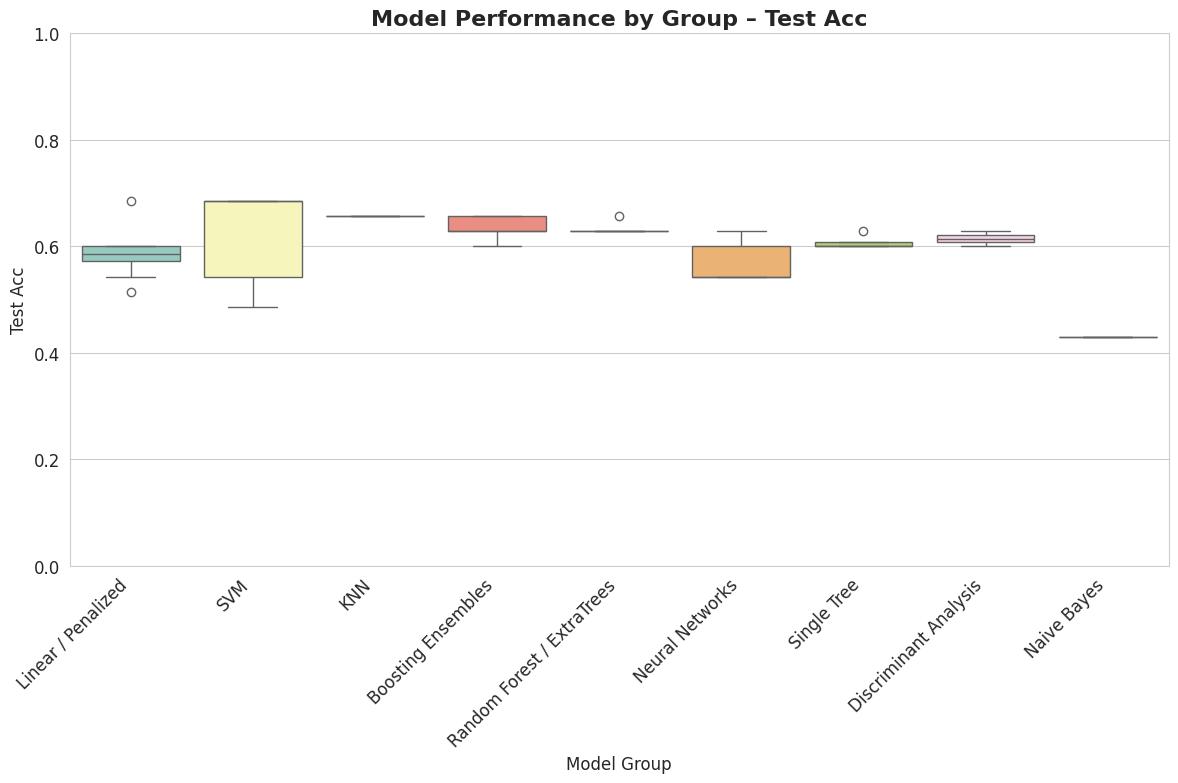

In [ ]:
# box plot by model groups
def plot_grouped_boxplot(results_df, metric='test_acc'):
    """Plot box plots of model performance by groups."""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    sns.boxplot(
        data=results_df, 
        x='Group', 
        y=metric,
        palette='Set3',
        ax=ax
    )
    
    ax.set_title(f'Model Performance by Group – {metric.replace("_", " ").title()}', 
                 fontsize=16, weight='bold')
    ax.set_xlabel('Model Group', fontsize=12)
    ax.set_ylabel(metric.replace("_", " ").title(), fontsize=12)
    ax.set_ylim(0.5, 1)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_grouped_boxplot(results_df, metric='test_acc')

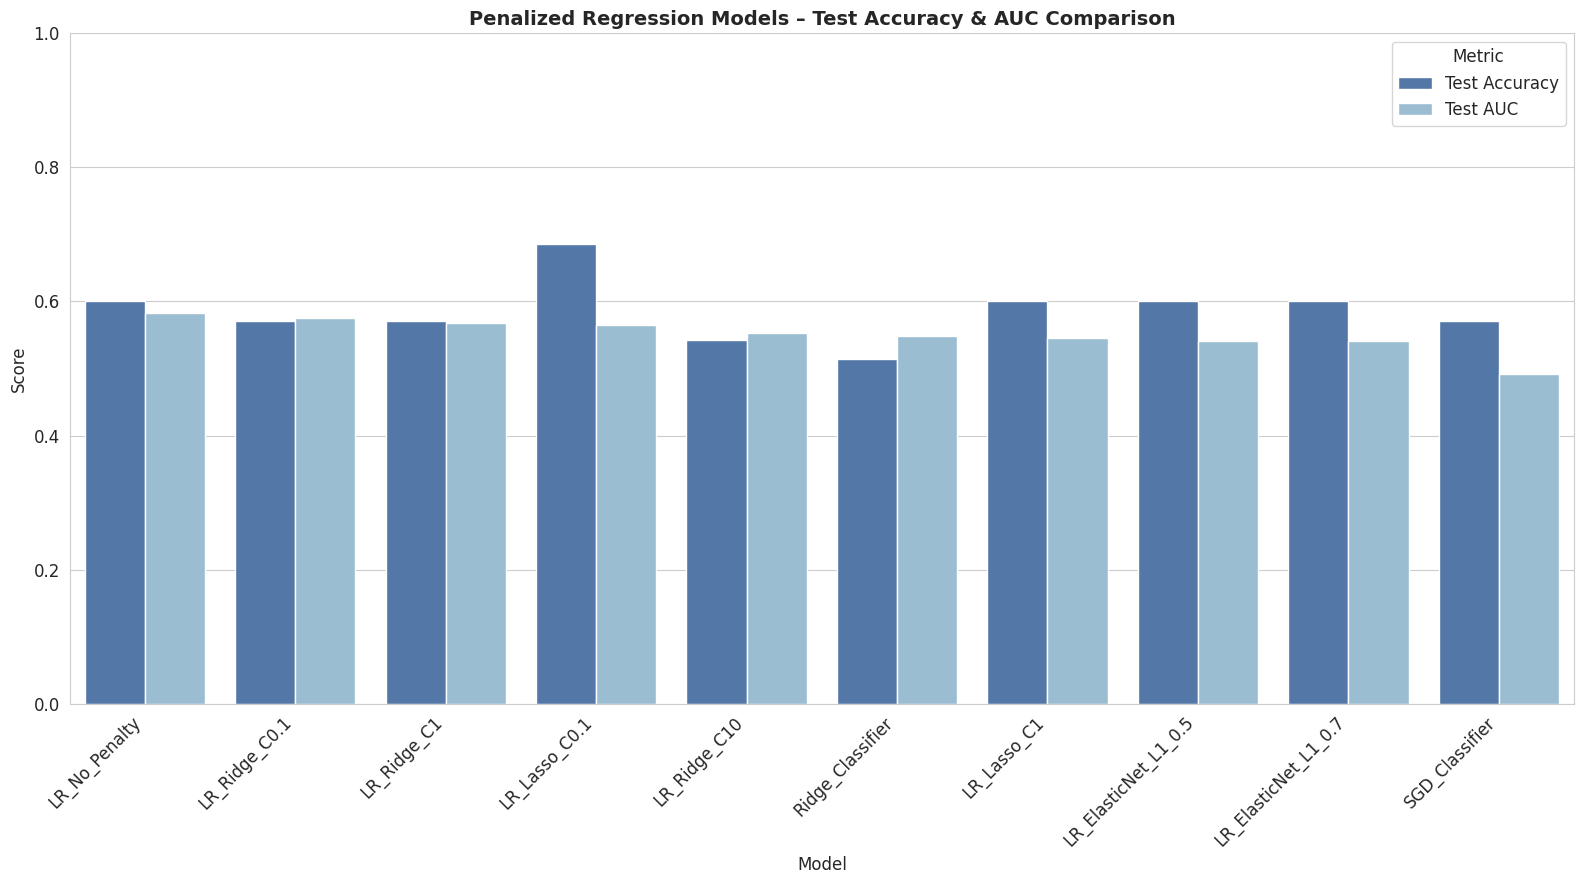

In [31]:
def plot_penalized_models(results_df):
    """Focus plot on penalized regression models with grouped bars for accuracy and AUC."""
    penalized = results_df[results_df['Group'] == 'Linear / Penalized'].copy()
    penalized = penalized.sort_values('test_auc', ascending=False)
    
    # Reshape data for grouped bar chart
    plot_data = penalized.melt(
        id_vars=['model'], 
        value_vars=['test_acc', 'test_auc'],
        var_name='Metric', 
        value_name='Score'
    )
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(16, 9))
    
    sns.barplot(
        data=plot_data, 
        x='model', 
        y='Score', 
        hue='Metric',
        dodge=True,
        ax=ax, 
        palette={'test_acc': '#4575b4', 'test_auc': '#91bfdb'}
    )
    
    ax.set_title('Penalized Regression Models – Test Accuracy & AUC Comparison', 
                 fontsize=14, weight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim(0, 1)
    
    # Get handles and labels, then update legend with custom labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=['Test Accuracy', 'Test AUC'], 
              title='Metric', loc='upper right')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

plot_penalized_models(results_df)


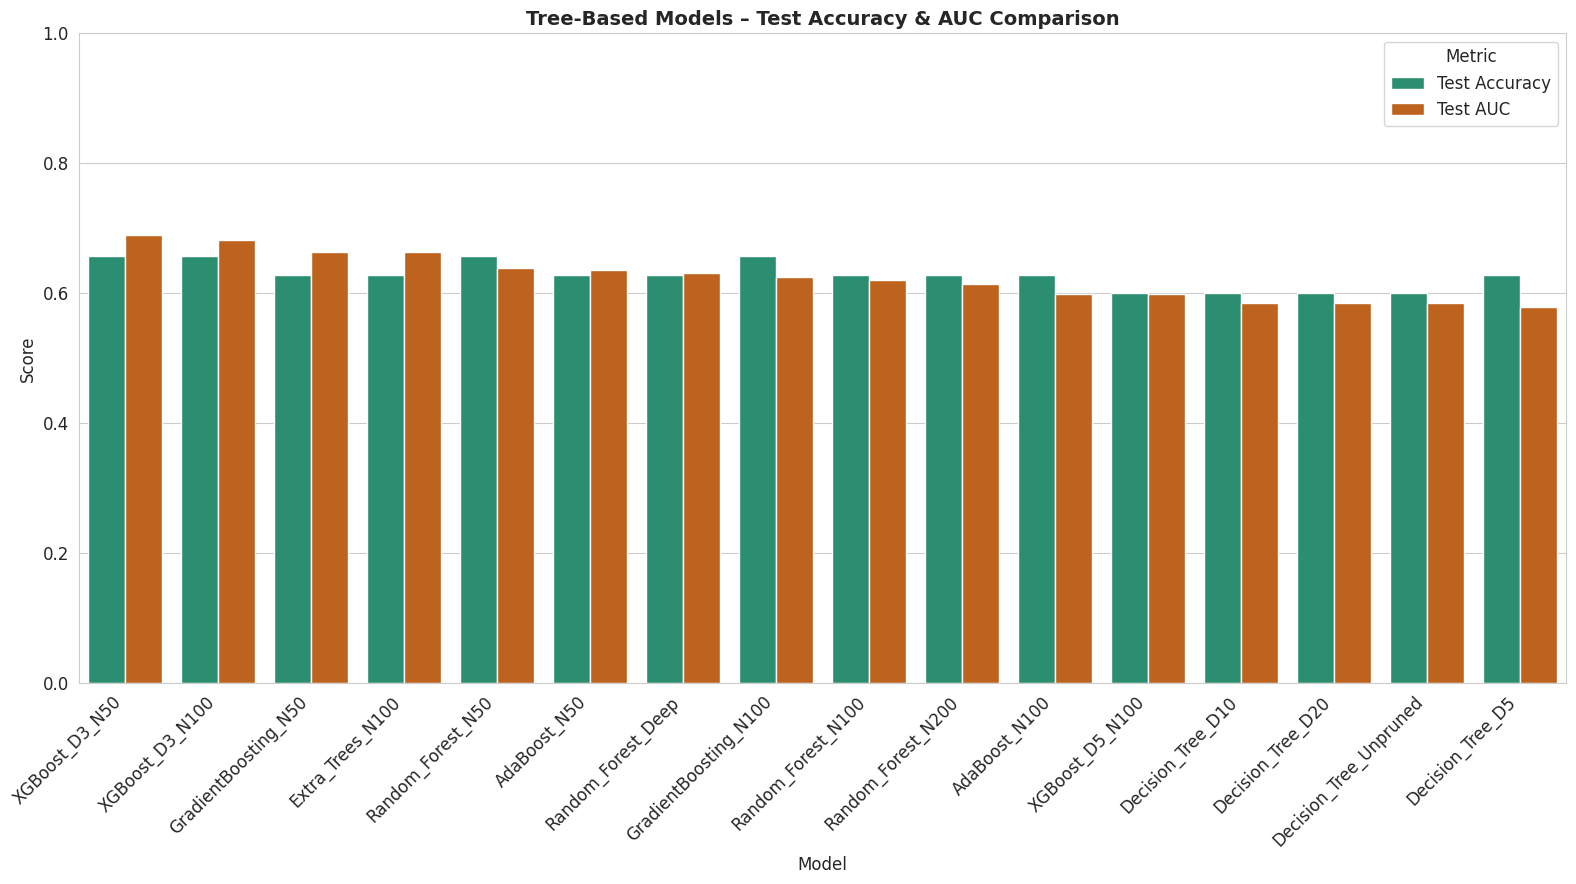

In [32]:
# plot tree based models
def plot_tree_based_models(results_df):
    """Focus plot on tree-based models with grouped bars for accuracy and AUC."""
    tree_based = results_df[results_df['Group'].isin(['Single Tree', 'Random Forest / ExtraTrees', 'Boosting Ensembles'])].copy()
    tree_based = tree_based.sort_values('test_auc', ascending=False)
    
    # Reshape data for grouped bar chart
    plot_data = tree_based.melt(
        id_vars=['model'], 
        value_vars=['test_acc', 'test_auc'],
        var_name='Metric', 
        value_name='Score'
    )
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(16, 9))
    
    sns.barplot(
        data=plot_data, 
        x='model', 
        y='Score', 
        hue='Metric',
        dodge=True,
        ax=ax, 
        palette={'test_acc': '#1b9e77', 'test_auc': '#d95f02'}
    )
    
    ax.set_title('Tree-Based Models – Test Accuracy & AUC Comparison', 
                 fontsize=14, weight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim(0, 1)
    
    # Get handles and labels, then update legend with custom labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=['Test Accuracy', 'Test AUC'], 
              title='Metric', loc='upper right')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

plot_tree_based_models(results_df)

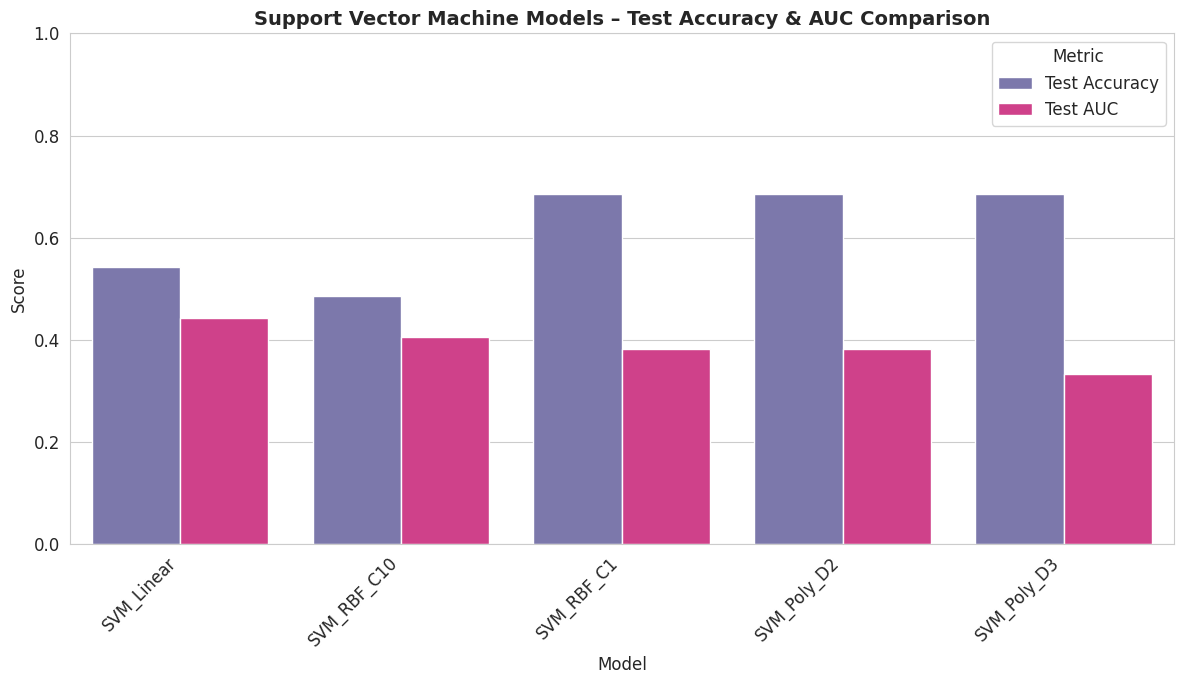

In [33]:
# plot support vector machine models
def plot_svm_models(results_df):
    """Focus plot on SVM models with grouped bars for accuracy and AUC."""
    svm_models = results_df[results_df['Group'] == 'SVM'].copy()
    svm_models = svm_models.sort_values('test_auc', ascending=False)
    
    # Reshape data for grouped bar chart
    plot_data = svm_models.melt(
        id_vars=['model'], 
        value_vars=['test_acc', 'test_auc'],
        var_name='Metric', 
        value_name='Score'
    )
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(12, 7))
    
    sns.barplot(
        data=plot_data, 
        x='model', 
        y='Score', 
        hue='Metric',
        dodge=True,
        ax=ax, 
        palette={'test_acc': '#7570b3', 'test_auc': '#e7298a'}
    )
    
    ax.set_title('Support Vector Machine Models – Test Accuracy & AUC Comparison', 
                 fontsize=14, weight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim(0, 1)
    
    # Get handles and labels, then update legend with custom labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=['Test Accuracy', 'Test AUC'], 
              title='Metric', loc='upper right')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

plot_svm_models(results_df)

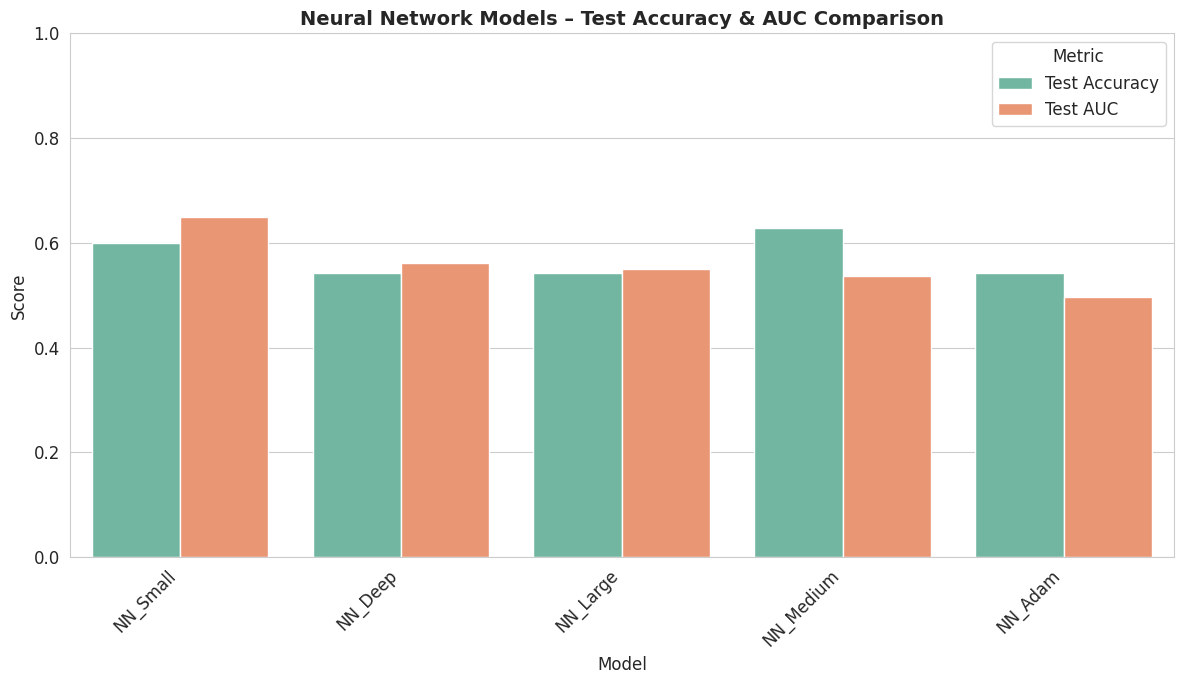

In [34]:
# plot Neural Network models
def plot_nn_models(results_df):
    """Focus plot on Neural Network models with grouped bars for accuracy and AUC."""
    nn_models = results_df[results_df['Group'] == 'Neural Networks'].copy()
    nn_models = nn_models.sort_values('test_auc', ascending=False)
    
    # Reshape data for grouped bar chart
    plot_data = nn_models.melt(
        id_vars=['model'], 
        value_vars=['test_acc', 'test_auc'],
        var_name='Metric', 
        value_name='Score'
    )
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(12, 7))
    
    sns.barplot(
        data=plot_data, 
        x='model', 
        y='Score', 
        hue='Metric',
        dodge=True,
        ax=ax, 
        palette={'test_acc': '#66c2a5', 'test_auc': '#fc8d62'}
    )
    
    ax.set_title('Neural Network Models – Test Accuracy & AUC Comparison', 
                 fontsize=14, weight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim(0, 1)
    
    # Get handles and labels, then update legend with custom labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=['Test Accuracy', 'Test AUC'], 
              title='Metric', loc='upper right')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

plot_nn_models(results_df)

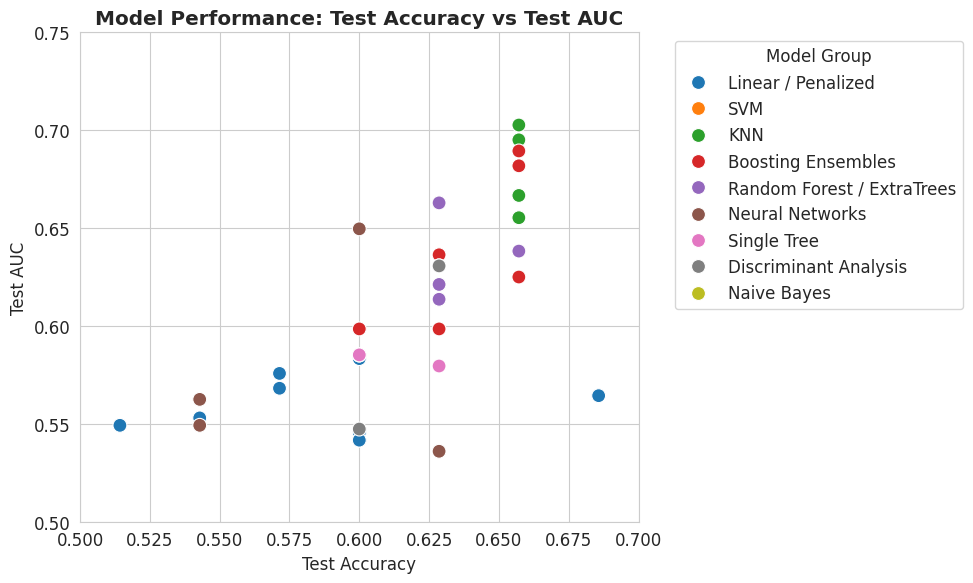

In [35]:

def plot_accuracy_vs_auc(results_df):
    """Scatter plot of accuracy vs AUC for all models."""
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=results_df, x='test_acc', y='test_auc', 
                    hue='Group', s=100, palette='tab10')
    plt.title('Model Performance: Test Accuracy vs Test AUC', weight='bold')
    plt.xlabel('Test Accuracy')
    plt.ylabel('Test AUC')
    plt.xlim(0.5, 0.7)
    plt.ylim(0.5, 0.75)
    plt.legend(title='Model Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



plot_accuracy_vs_auc(results_df)

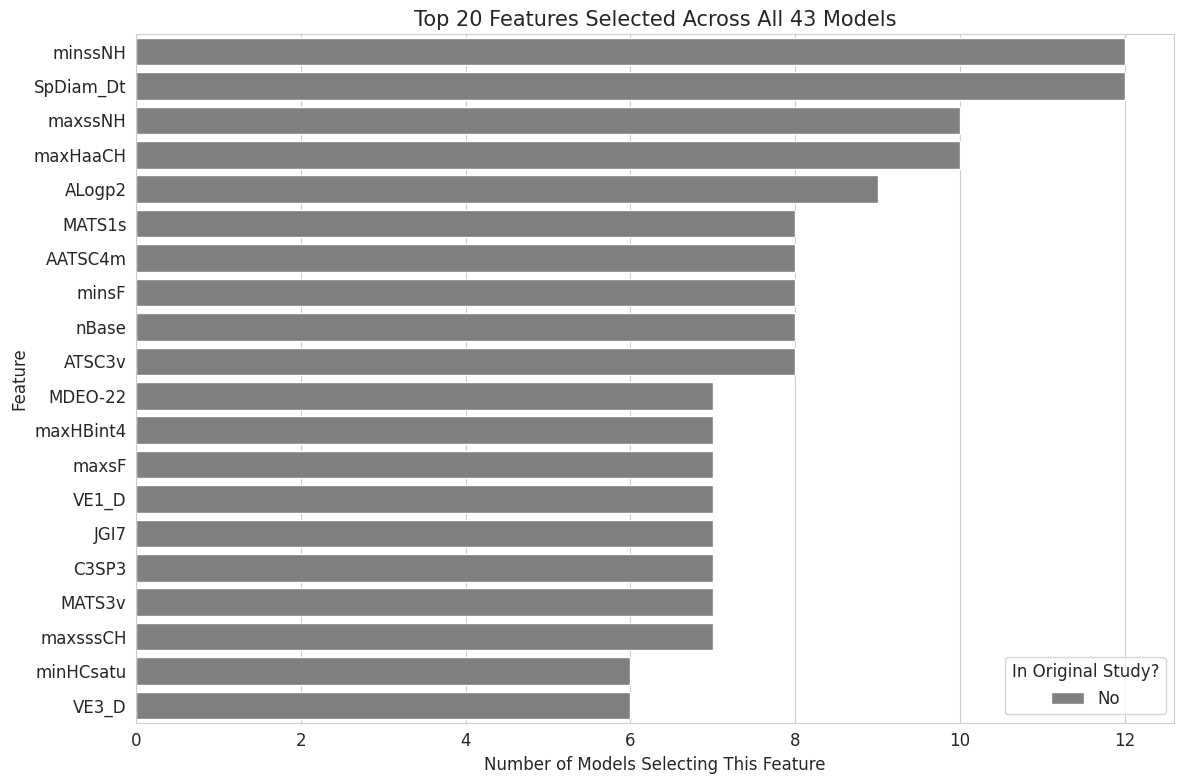

In [36]:
all_top_features = []
for comp in feature_comparison.values():
    all_top_features.extend(comp['top_13'])

feat_counts = pd.Series(all_top_features).value_counts().head(20)
feat_df = feat_counts.reset_index()
feat_df.columns = ['Feature', 'Frequency']

# Color code: Is it in the original study?
feat_df['In_Original_Study'] = feat_df['Feature'].apply(lambda x: 'Yes' if x in original_features else 'No')

plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Feature', data=feat_df, hue='In_Original_Study', dodge=False, palette={'Yes': 'green', 'No': 'gray'})
plt.title(f'Top 20 Features Selected Across All {len(models)} Models', fontsize=15)
plt.xlabel('Number of Models Selecting This Feature')
plt.legend(title='In Original Study?')
plt.tight_layout()
plt.show()

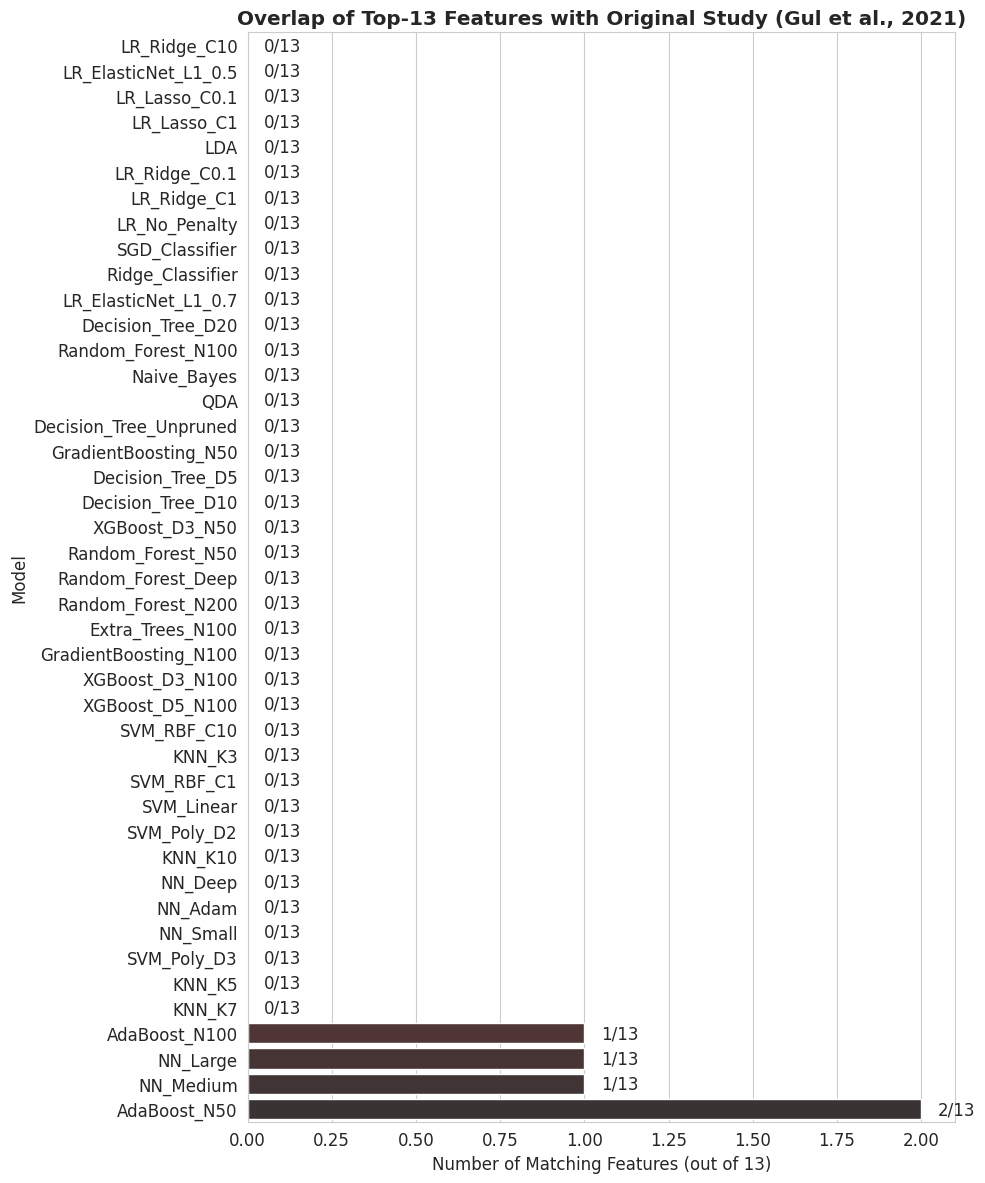

In [37]:

def plot_feature_overlap(summary_df):
    """Plot feature overlap with original study."""
    overlap_df = summary_df.sort_values('Overlap Count', ascending=True)
    
    plt.figure(figsize=(10, 12))
    sns.barplot(data=overlap_df, y='Model', x='Overlap Count', palette='Reds_d')
    plt.title('Overlap of Top-13 Features with Original Study (Gul et al., 2021)', weight='bold')
    plt.xlabel('Number of Matching Features (out of 13)')
    
    # Add value labels
    for i, row in enumerate(overlap_df.itertuples()):
        plt.text(row._2 + 0.05, i, f'{row._2}/13', va='center')
    
    plt.tight_layout()
    plt.show()

plot_feature_overlap(summary_df)

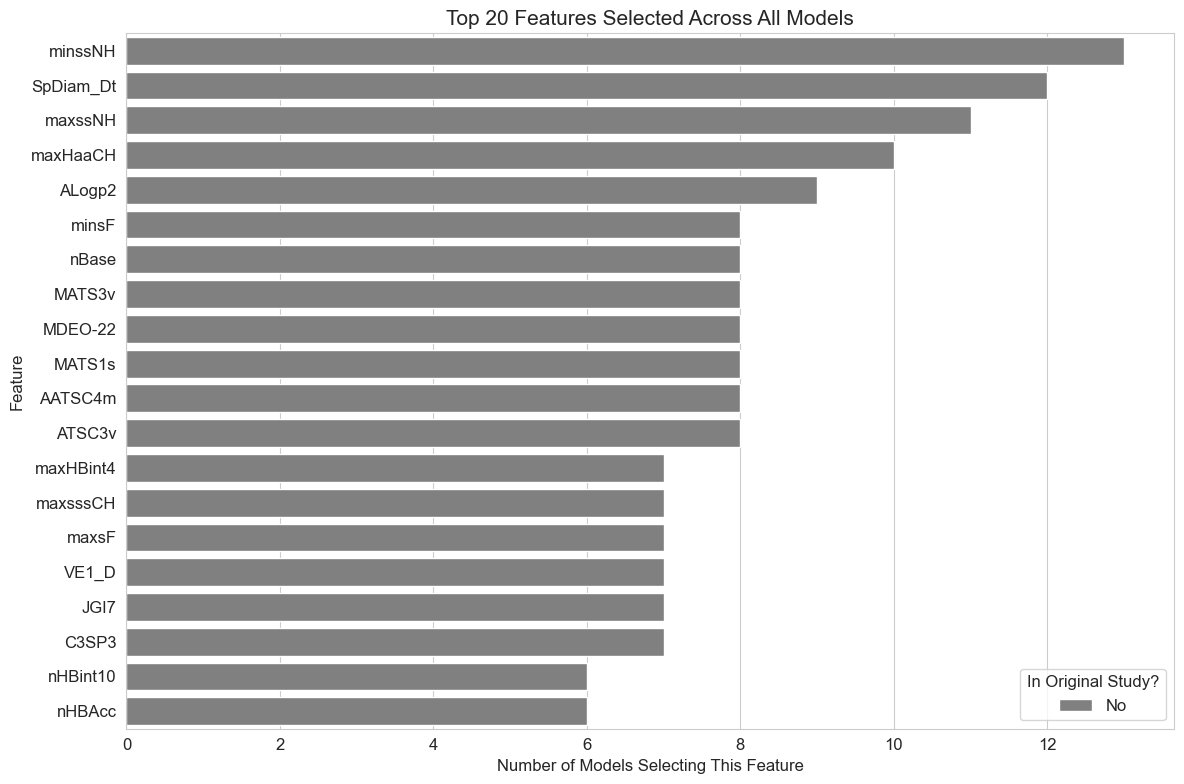

In [ ]:


def plot_feature_consistency(feature_comparison, original_features, top_n=20):
    """Plot feature selection consistency across models."""
    # Count feature appearances
    all_top_features = []
    for comp in feature_comparison.values():
        all_top_features.extend(comp['top_13'])
    
    feat_counts = pd.Series(all_top_features).value_counts().head(top_n)
    feat_df = feat_counts.reset_index()
    feat_df.columns = ['Feature', 'Frequency']
    feat_df['In_Original_Study'] = feat_df['Feature'].apply(
        lambda x: 'Yes' if x in original_features else 'No'
    )
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Frequency', y='Feature', data=feat_df, 
                hue='In_Original_Study', dodge=False, 
                palette={'Yes': 'green', 'No': 'gray'})
    plt.title(f'Top {top_n} Features Selected Across All Models', fontsize=15)
    plt.xlabel('Number of Models Selecting This Feature')
    plt.legend(title='In Original Study?')
    plt.tight_layout()
    plt.show()



plot_feature_consistency(feature_comparison, original_features)

In [ ]:

# If you have comparison data and feature data:
# plot_class_weighting_impact(comparison_df)
# plot_feature_overlap(summary_df)
# plot_feature_consistency(feature_comparison, original_features)